# Anomaly Detection

Anomaly detection is a technique used to identify unusual patterns that do not conform to expected behavior, called outliers. This idea is often used in fraud detection, manufacturing or monitoring of machines. 
The Anomaly detection algorithm can be implemented in several ways. Here we will show two methods: **Normal Gaussian Distribution** and **Multivariate Gaussian Distribution**. <br>

### Normal Gaussian Distribution

Using a *Normal Gaussian Distribution* algorithm implies that the example $x$ is distributed with a mean $Mu$ and variance $Sigma$ squared. <br>
The steps to build the algorithm are: <br>

1- Choose the features $x$ that might be indicative of anomalous examples <br>
2- Calculate the parameters $Mu$ and $Sigma$ <br>
3- Compute the probability $p$ of $x$ <br>
4- Calculate the best threshold (epsilon value) based on the best F1-score using Cross Validation set<br>

$$\mu_j = \frac{1}{m}\sum_{i=1}^m x_j^{(i)} $$ <br>
$$\sigma_j^{2} = \frac{1}{m}\sum_{i=1}^m (x_j^{(i)} - \mu_j)^{2} $$ <br>

The formula for calculating the probability is:
$$p(x) = \prod_{j=1}^{n} p(x_j; \mu_j, \sigma_j^{2}) = \prod_{j=1}^{n} \frac{1}{\sqrt{2\pi}\sigma_j} \exp(- \frac{(x_j - \mu_j)^2}{2\sigma_j^2})$$

### Multivariate Gaussian Distribution

In certain cases the Normal Gaussian Distribution is not enough the accurately flag anomalies. A multivariat Gaussian distribution calculates the probability model of $x$ at once, instead of modelling the probabilities for each feature alone. It uses a covariance matrix instead of Sigma squared.
The steps to build the algorithm are: <br>

1- Choose the features $x$ that might be indicative of anomalous examples <br>
2- Calculate the parameters $Mu$ and $Covariance$ <br>
3- Compute the probability $p$ of $x$ <br>
4- Calculate the best threshold (epsilon value) based on the best F1-score using Cross Validation set<br>

$$\mu_j = \frac{1}{m}\sum_{i=1}^m x_j^{(i)} $$ <br>
$$cov = \frac{1}{m}\sum_{i=1}^m (x^{(i)} - \mu) (x^{(i)} - \mu)^T $$ <br>
The formula for calculating the probability is:
$$p(x; \mu, cov) = \frac{1}{(2\pi)^{\frac{n}{2}}|cov|^{\frac{1}{2}}} \exp\Big(- \frac{1}{2} (x - \mu)^T cov^{-1} (x - \mu)\Big)$$

### Practical Tips and difference to a Supervised Learning system

An anomaly detection system should be used if:

  $\bullet$ a large number of negative examples but a small number of positives examples are available <br>
  $\bullet$ the anomalies themselves cannot be classified and may vary in future examples <br>
  
If a classification can easily be done, ie having large numbers of positive and negative examples and future examples will be similar, it is advisable to use a supervised learning algorithm.

To analyse errors it makes sense to plot the features and see if they behave Gaussian. If not, constants (like log(x)) can be added, to try to make it look as Gaussian as possible.

The basic assumption for using anomaly detection system is to have few anomalous examples and many normal ones. If this is not met, the misclassified example should be inspected in order see if we can come up with a new feature that allows us to correctly classify anomalies.

If we use the **Normal Gaussian Distribution** it is probable that we manually need to create features to capture anomalies where the combination of other features take unusual values. For example if we have the features $x1$ (CPU load) and $x2$ (memory) that combined together (for example like $\frac{CPU load}{memory}$) assume an unusual value, we may need to create a new feature to capture these anomalies.
Normal Gaussian Distribution is computionally cheaper, scales better on large training sets size but works fine also on small training sets size.

Since **Multivariate Gaussian Distribution** use covariance matrix, it automatically catures correlations between features. So we do not need to manually create new feature.
This algorithm is computationally more expensive that the previous.
Moreover, it must have $m > n$ or else convariance matrix is non-invertible.

### Excercise
In this exercise, we will implement an anomaly detection algorithm to detect anomalous behaviour in server computers. The features measure the throughput (mb/s) and latency (ms) of response of each server. While our servers were operating, we collected $m$ = 307 examples of how they were behaving, and thus have an unlabeled dataset $ \{{x^{(1)}, \dots, x^{(m)}} \}$. We suspect that the vast majority of these examples are "normal" (non-anomalous), but there might also be some examples of servers acting anomalously within this dataset.
We will use Gaussian models to detect anomalous examples in our dataset.

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from numpy.linalg import inv

## Functions

In [233]:
def estimateGaussian(X):
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    return mu, sigma

def gaussianDistribution(X, mu, sigma):
    first = 1/np.sqrt(2*np.pi)*np.sqrt(sigma)
    second = -((X - mu)**2)/(2*sigma)
    return np.prod(first*np.exp(second), axis=1).reshape(-1, 1)

def estimateMultivariateGaussian(X):
    mu = np.mean(X, axis=1)
    cov = np.cov(X)
    return mu, cov

def selectThreshold(yval, pval):
    bestEpsilon = 0
    bestF1 = 0
    F1 = 0
    stepsize = (max(pval) - min(pval)) / 1000
    for epsilon in np.arange(min(pval), max(pval), stepsize):
        cvPredictions = np.where(pval < epsilon, 1, 0)
        tp = sum((cvPredictions == 1) & (yval == 1))
        fp = sum((cvPredictions == 1) & (yval == 0))
        fn = sum((cvPredictions == 0) & (yval == 1))
        
        precision = (tp) / (tp +  fp)
        recall = (tp) / (tp +  fn)

        F1 = (2* precision * recall)/(precision + recall)
        
        if F1 > bestF1:
            bestF1 = F1
            bestEpsilon = epsilon
    return bestEpsilon, bestF1
    

## Normal Gaussian Distribution

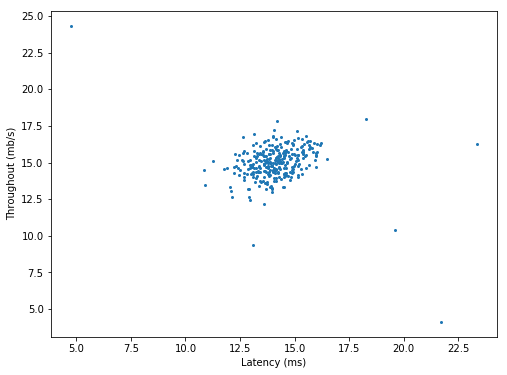

In [246]:
data = sio.loadmat('ex8data1.mat')
X = data['X']
fig = plt.figure(figsize=(8,6))
plt.scatter(X[:, 0], X[:, 1], s=4)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughout (mb/s)')
plt.show()

In [247]:
Xval = data['Xval']
yval = data['yval']
mu, sigma = estimateGaussian(X)
p = gaussianDistribution(X, mu, sigma)
pval = gaussianDistribution(Xval, mu, sigma)
epsilon, F1 = selectThreshold(yval, pval)
print("F1-score={0}, epsilon={1}, number_of_anomalies={2}".format(F1, epsilon, sum(p < epsilon)))

/home/pptr/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


F1-score=[0.875], epsilon=0.00021173900744569037, number_of_anomalies=[6]


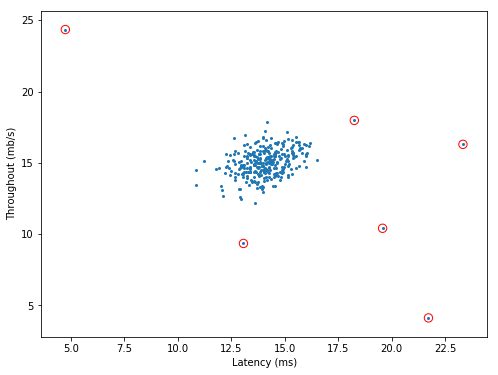

In [248]:
fig = plt.figure(figsize=(8,6))
plt.scatter(X[:, 0], X[:, 1], s=4)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughout (mb/s)')
plt.scatter(X[(p < epsilon).nonzero()[0], 0], X[(p < epsilon).nonzero()[0], 1], s=70, color='red', facecolors='none')
plt.show()

### Normal Gaussian Distribution on dataset with many examples compared to the features

In [249]:
data2 = sio.loadmat('ex8data2.mat')
X = data2['X']
Xval = data2['Xval']
yval = data2['yval']

mu, sigma = estimateGaussian(X)

# Training set 
p = gaussianDistribution(X, mu, sigma)

# Cross-validation set
pval = gaussianDistribution(Xval, mu, sigma)

# Find the best threshold
epsilon, F1 = selectThreshold(yval, pval)
print("F1-score={0}, epsilon={1}, number_of_anomalies={2}".format(F1, epsilon, sum(p < epsilon)))

/home/pptr/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


F1-score=[0.19047619], epsilon=1.1683165534847689e-08, number_of_anomalies=[921]


It can be noticed that we have obtained a poor F1-score. This is because the number of examples is much larger than the number of feature.
In this case the **Multivariate Gaussian Distribution** model is worth to be considered.
It captures correlations between features but is computational expensive. When it is obvious what feature combinations can capture the anomalies, it is advisable to first implement those with the original Normal Gaussian Distribution model.

## Multivariate Gaussian distribution

In [250]:
from scipy.stats import multivariate_normal
data = sio.loadmat('ex8data2.mat')
X = data['X']
Xval = data['Xval']
yval = data['yval']

mu, cov = estimateMultivariateGaussian(X.T)
p = multivariate_normal.pdf(X, mean=mu, cov=cov).reshape(-1, 1)
pval = multivariate_normal.pdf(Xval, mean=mu, cov=cov).reshape(-1, 1)
epsilon, F1 = selectThreshold(yval, pval)
print("F1-score={0}, epsilon={1}, number_of_anomalies={2}".format(F1, epsilon, sum(p < epsilon)))

/home/pptr/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


F1-score=[0.55172414], epsilon=1.7464996396712342e-18, number_of_anomalies=[122]
